#### Creation of RumorAgent and RumorModel

##### First, we defined different possible states for agents in this model. The possible states are:
- S (Susceptible): hasn’t seen the anti-vax rumor yet.
- B (Believer): believes and spreads it.
- R (Recovered): exposed to fact-checks or social “refutation” and won’t believe again.
- V (Vaccinated): has proactively received accurate vaccine information (via official campaigns) and cannot transition to B.
- Z (Zealot): a hardcore anti-vax influencer who:
  - Spreads more aggressively (higher transmission probability),
  - Has very low chance of ever moving to R.

##### Than, we have to define our actual RumorAgent that has initial states set to SUSPECTIBLE. In the step method we define the agents behavior. After that we create a model. We define a model using:
- N - number of agents
- k - number of connections each agent has to it's neighbors
- p_rewire - probability of rewiring an edge
- p_V - probability that the agent is initialized with state VACCINATED
- p_Z - probability that the agent is initialized with state ZEALOT
- p_B - probability that the agent is initialized with state BELIEVER

##### We use Watts-Strogatz small-world network as a grid for our model

In [2]:
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# define the possible states for agents
SUSCEPTIBLE = "S"
BELIEVER = "B"
RECOVERED = "R"
VACCINATED = "V"
ZEALOT = "Z"

STATE_COLORS = {
    "S": "blue",      # Susceptible
    "B": "red",       # Believer
    "R": "green",     # Recovered
    "V": "orange",    # Vaccinated
    "Z": "purple"     # Zealot
}

class RumorAgent(Agent):
    def __init__(self, model, initial_state=SUSCEPTIBLE):
        super().__init__(model)
        self.state = initial_state

    def step(self):
        if self.state == SUSCEPTIBLE:
            # check neighbors for infection
            for neighbor in self.model.grid.get_neighbors(self.pos, include_center=False):
                if neighbor.state == BELIEVER and random.random() < self.model.beta:
                    self.state = BELIEVER
                    break
                if neighbor.state == ZEALOT and random.random() < self.model.beta_z:
                    self.state = BELIEVER
                    break
        elif self.state == BELIEVER:
            # skepticism threshold: if enough believer neighbors, recover
            neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
            b_neighbors = sum(1 for neighbor in neighbors if neighbor.state == BELIEVER)
            if b_neighbors >= self.model.theta:
                self.state = RECOVERED
        # VACCINATED, RECOVERED, ZEALOT have no automatic transitions here

class RumorModel(Model):
    def __init__(self, N=1000, k=10, p_rewire=0.1,
                 p_V=0.1, p_Z=0.01, p_B=0.02,
                 beta=0.03, beta_z=0.08, theta=3,
                 C_V=0, C_Z=0,
                 p_fact_check=0.1,
                 p_vaccination = 0.8, #prob. that someone becomes vaccinated
                 seed=None):
        super().__init__(seed=seed)
        self.num_agents = N
        self.beta = beta
        self.beta_z = beta_z
        self.theta = theta
        self.C_V = C_V  # daily proactive inoculations
        self.C_Z = C_Z  # daily targeted fact-checks
        self.p_vaccination = p_vaccination #Used in proactive_inoculation_with_probability to determine success of conversion
        self.p_fact_check = p_fact_check # per‐attempt conversion success

        # create a Watts-Strogatz small-world network
        self.G = nx.watts_strogatz_graph(n=N, k=k, p=p_rewire)
        self.grid = NetworkGrid(self.G)

        # DataCollector to track counts of each state
        self.datacollector = DataCollector(
            model_reporters={
                "Susceptible": lambda m: RumorModel.count_state(m, SUSCEPTIBLE),
                "Believer": lambda m: RumorModel.count_state(m, BELIEVER),
                "Recovered": lambda m: RumorModel.count_state(m, RECOVERED),
                "Vaccinated": lambda m: RumorModel.count_state(m, VACCINATED),
                "Zealot": lambda m: RumorModel.count_state(m, ZEALOT)
            }
        )

        # initialize agents - assigning initial states
        for node in self.G.nodes():
            if random.random() < p_Z:
                state = ZEALOT
            elif random.random() < p_V:
                state = VACCINATED
            elif random.random() < p_B:
                state = BELIEVER
            else:
                state = SUSCEPTIBLE

            # creating an agent automatically adds it to model.agents
            agent = RumorAgent(self, initial_state=state)
            # place agent on its corresponding network node
            self.grid.place_agent(agent, node)

    def proactive_inoculation_with_probability(self):
        # Convert susceptible agents to vaccinated with a probability, using C_V as expected number
        susceptible_agents = [agent for agent in self.agents if agent.state == SUSCEPTIBLE]

        # Use Gaussian approximation to determine actual number to attempt
        expected = self.C_V
        num_attempts = min(len(susceptible_agents), max(0, int(random.gauss(expected, expected**0.5))))

        if num_attempts > 0:
            to_consider = random.sample(susceptible_agents, num_attempts)
            for agent in to_consider:
                if random.random() < self.p_vaccination:  # succeed with probability
                    agent.state = VACCINATED


    def targeted_fact_check(self):
        # 1 attempt to convert up to C_Z zealots (highest‐degree first), but only succeed with p_fact_check
        # first collect all zealots
        zealot_agents = [a for a in self.agents if a.state == ZEALOT]
        # sort zealots by degree using agent.pos (node)
        zealot_agents.sort(key=lambda a: self.G.degree[a.pos], reverse=True)
        converted = 0
        for zealot in zealot_agents:
            if converted >= self.C_Z:
                break
            if random.random() < self.p_fact_check:      # only flip with probability
                zealot.state = RECOVERED
                converted += 1

        # 2 if budget remains try the same for believers
        if converted < self.C_Z:
            believer_agents = [a for a in self.agents if a.state == BELIEVER]
            believer_agents.sort(key=lambda a: self.G.degree[a.pos], reverse=True)
            for b in believer_agents:
                if converted >= self.C_Z:
                    break
                if random.random() < self.p_fact_check:
                    b.state = RECOVERED
                    converted += 1

    def step(self):
        # first, apply interventions
        if self.C_V > 0:
            self.proactive_inoculation_with_probability()
        if self.C_Z > 0:
            self.targeted_fact_check()

        # collect state counts
        self.datacollector.collect(self)
        # activate all agents in random order
        self.agents.shuffle_do("step")

    @staticmethod
    def run_batch(num_runs=3, steps=50, c_v=10, c_z=5, params=None):
        all_data = []
        for run_id in range(num_runs):
            model = RumorModel(C_V=c_v, C_Z=c_z, **(params or {}), seed=run_id)
            for _ in range(steps):
                model.step()
            run_df = model.datacollector.get_model_vars_dataframe()
            prevalence = (run_df['Believer'] + run_df['Zealot']) / model.num_agents
            prevalence.name = f'run_{run_id}'
            all_data.append(prevalence)
        return pd.concat(all_data, axis=1)

    @staticmethod
    def count_state(model, state):
        return sum(1 for agent in model.agents if agent.state == state)


#### Testing the model

##### We tested the model by trying out different values for C_V and C_Z. 

##### First we tested the proportion of B+Z if there is no intervention in the model, so C_V=0 and C_Z=0. We can see that in that case the proportion plateau at certain point after certain number of steps because at the end when we have no more agents with state SUSCEPTIBLE we have no more interactions between agents. Similar thing happens when we have C_V set and no C_Z, because C_V intervention means that we take random sample of agents that are at state SUSCEPTIBLE and make them into VACCINATED to simulate the effect of propaganda campaign. That means that it is going to have effect until there are agents with state SUSCEPTIBLE and if there are no agents with that state, there is no effect anymore. The effect that we can see which C_V produces is that the final number of B+Z is lower. 

##### Now, when we set C_Z to a certain number, we can see that it influences a lot. To recap, C_Z means that we take Z, or B agents if there are not enough Z agents, and transform them into RECOVERED. That effect is to simulate the targeted campaings and their influence. As we can see in that situation the final number of B+Z is 0 and we can also see that if C_V works alongside C_Z we get to the point of B+Z=0 faster.

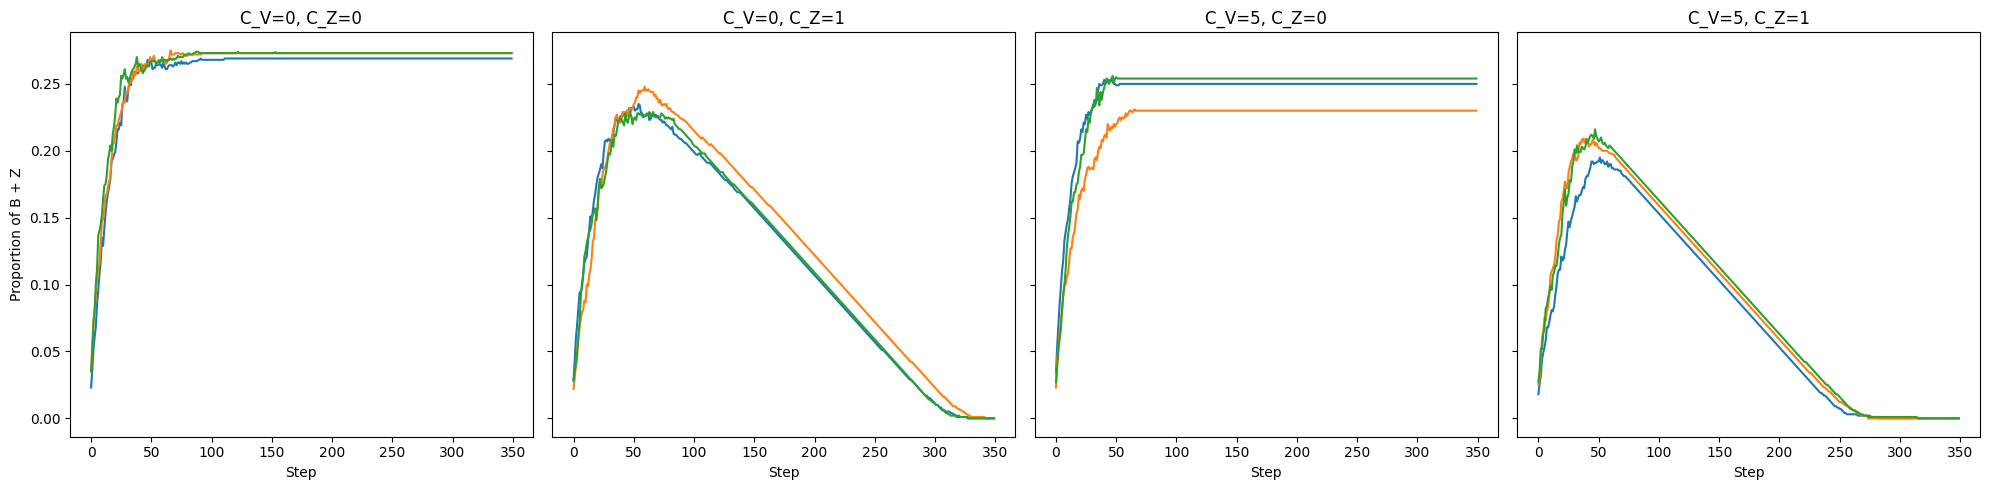

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, (c_v, c_z) in zip(axes, [(0, 0), (0, 1), (5, 0), (5, 1)]):
    batch_df = RumorModel.run_batch(num_runs=3, steps=350, c_v=c_v, c_z=c_z)
    for column in batch_df.columns:
        ax.plot(batch_df.index, batch_df[column])
    ax.set_xlabel('Step')
    ax.set_ylabel('Proportion of B + Z')
    ax.set_title(f'C_V={c_v}, C_Z={c_z}')
    ax.label_outer()

plt.tight_layout()
plt.show()


#### Network evolution

##### Now, to actually see how the network behaves, we created snapshots of networks by making a plot at certain number of steps. We can see how the outcomes differentiate and how the agents evolve in the network over time depending on the C_V and C_Z.

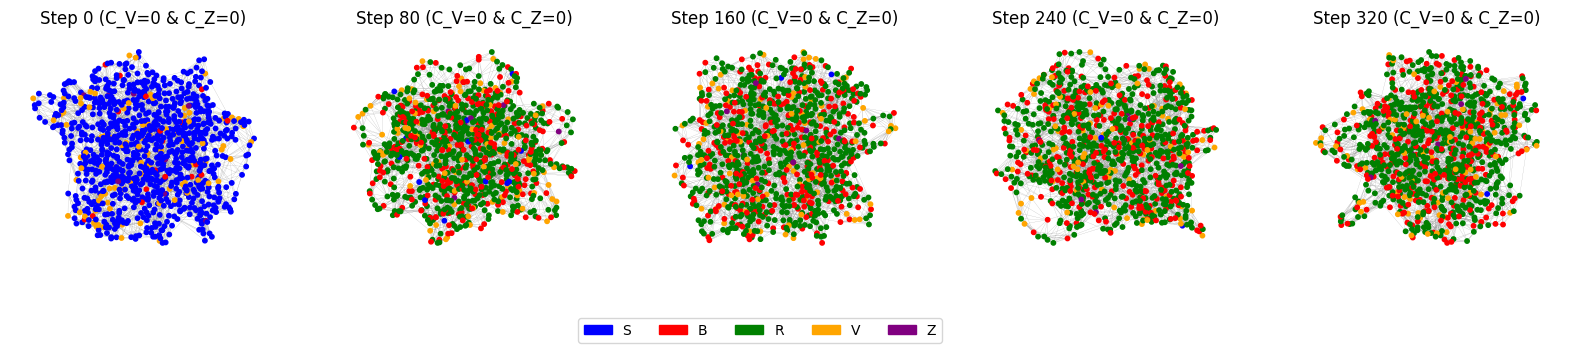

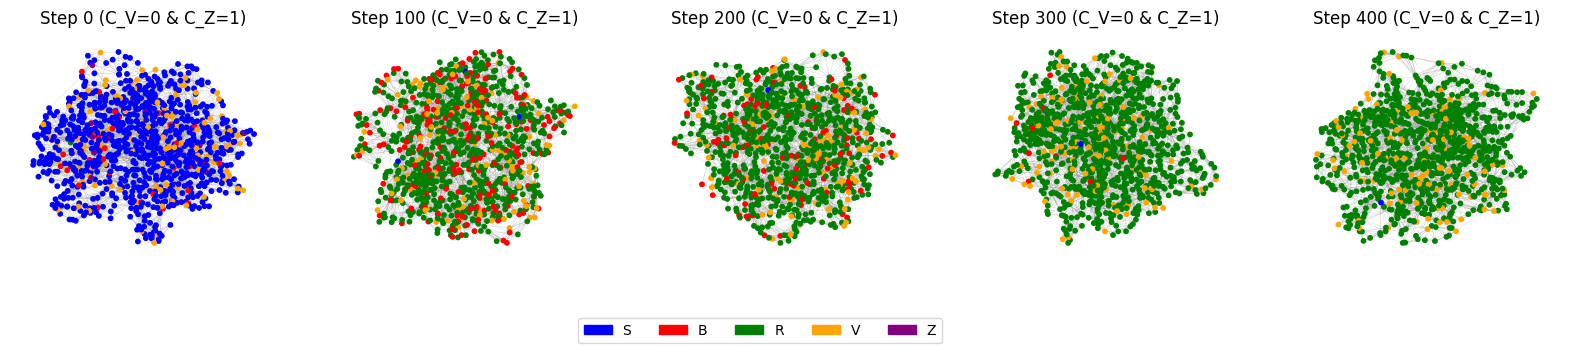

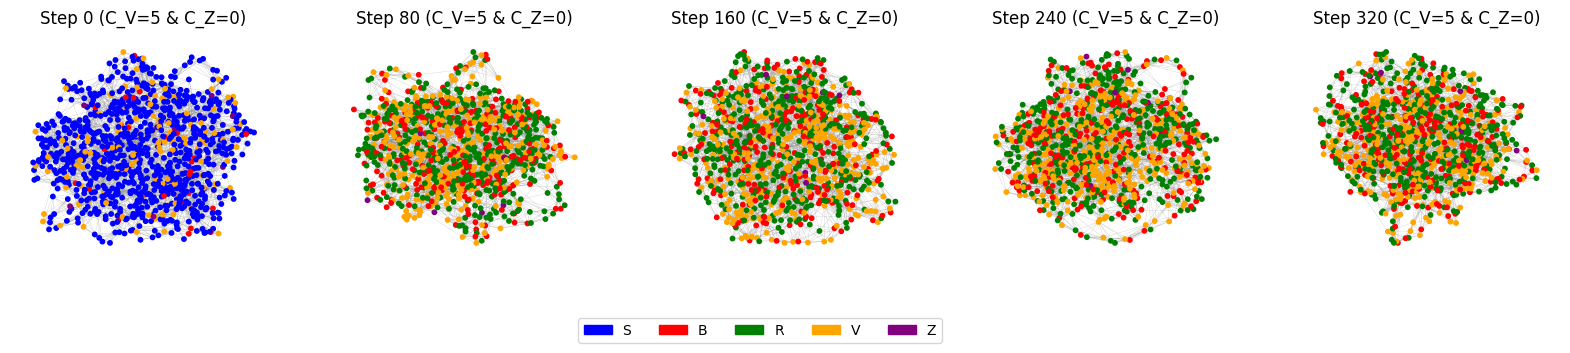

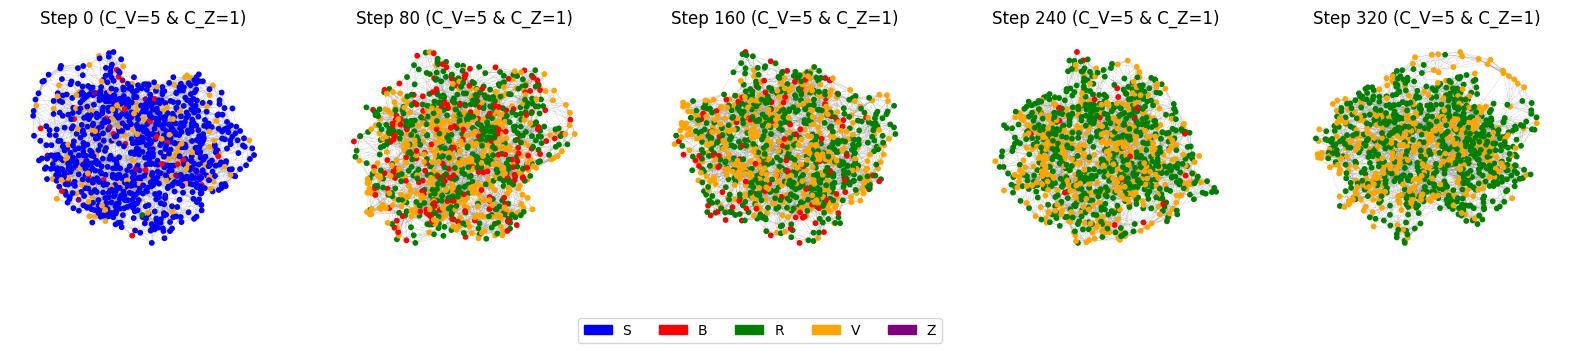

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

def plot_network(step_count=0, plot_at_step=1, steps=1, cv=0, cz=0):
    node_colors = []
    for node in model.G.nodes():
        agent = model.grid.get_cell_list_contents([node])[0]
        node_colors.append(STATE_COLORS[agent.state])
    pos = nx.spring_layout(model.G)
    plt.subplot(1, int(steps/plot_at_step), step_count//plot_at_step + 1)
    nx.draw(model.G, pos=pos, node_color=node_colors, node_size=10, edge_color='gray', width=0.1)
    plt.title(f"Step {step_count} (C_V={cv} & C_Z={cz})")
    plt.axis('off')

# helper to build one set of legend patches
legend_patches = [mpatches.Patch(color=STATE_COLORS[s], label=s) for s in STATE_COLORS]

# ─────────────────────────────────────────────────────────────────────
cv = 0
cz = 0
model = RumorModel(C_V=cv, C_Z=cz, seed=0)
fig = plt.figure(figsize=(20, 3))
steps = 400
for i in range(steps):
    model.step()
    plot_at_step = 80
    if i % plot_at_step == 0:
        plot_network(i, plot_at_step, steps, cv, cz)
fig.legend(handles=legend_patches, loc='upper center', ncol=len(STATE_COLORS), bbox_to_anchor=(0.5, -0.05))
plt.show()

# ─────────────────────────────────────────────────────────────────────
cv = 0
cz = 1
model = RumorModel(C_V=cv, C_Z=cz, seed=0)
fig = plt.figure(figsize=(20, 3))
steps = 500
for i in range(steps):
    model.step()
    plot_at_step = 100
    if i % plot_at_step == 0:
        plot_network(i, plot_at_step, steps, cv, cz)
fig.legend(handles=legend_patches, loc='upper center', ncol=len(STATE_COLORS), bbox_to_anchor=(0.5, -0.05))
plt.show()

# ─────────────────────────────────────────────────────────────────────
cv = 5
cz = 0
model = RumorModel(C_V=cv, C_Z=cz, seed=0)
fig = plt.figure(figsize=(20, 3))
steps = 400
for i in range(steps):
    model.step()
    plot_at_step = 80
    if i % plot_at_step == 0:
        plot_network(i, plot_at_step, steps, cv, cz)
fig.legend(handles=legend_patches, loc='upper center', ncol=len(STATE_COLORS), bbox_to_anchor=(0.5, -0.05))
plt.show()

# ─────────────────────────────────────────────────────────────────────
cv = 5
cz = 1
model = RumorModel(C_V=cv, C_Z=cz, seed=0)
fig = plt.figure(figsize=(20, 3))
steps = 400
for i in range(steps):
    model.step()
    plot_at_step = 80
    if i % plot_at_step == 0:
        plot_network(i, plot_at_step, steps, cv, cz)
fig.legend(handles=legend_patches, loc='upper center', ncol=len(STATE_COLORS), bbox_to_anchor=(0.5, -0.05))
plt.show()

#### Mann-Whitney U test

In [8]:
from scipy.stats import mannwhitneyu

# define scenarios:
inoc_only = [(c_v, 0) for c_v in (5, 10, 20)]
fact_only = [(0, c_z) for c_z in (1, 5, 10)]
combo    = [(10, 5), (20, 5), (10, 10)]
no_intervention = [(0, 0)]
all_scenarios = inoc_only + fact_only + combo + no_intervention

# prepare a DataFrame to hold all summary stats
results = []

for (c_v, c_z) in all_scenarios:
    # run num_runs independent replicates, steps steps each
    batch_df = RumorModel.run_batch(num_runs=20, steps=100, c_v=c_v, c_z=c_z)

    for run_col in batch_df.columns:
        timeseries = batch_df[run_col]  # length = 100
        peak_prev = timeseries.max()    # fraction B+Z
        time_to_peak = timeseries.idxmax()
        # to get final R+V we need one more run to fetch R and V counts:
        model = RumorModel(C_V=c_v, C_Z=c_z, seed=int(run_col.split('_')[1]))
        for _ in range(100):
            model.step()
        final_R = model.datacollector.get_model_vars_dataframe()['Recovered'].iloc[-1]
        final_V = model.datacollector.get_model_vars_dataframe()['Vaccinated'].iloc[-1]
        final_immune = (final_R + final_V) / model.num_agents

        results.append({
            'C_V': c_v,
            'C_Z': c_z,
            'run_id': run_col,
            'peak_prevalence': peak_prev,
            'time_to_peak': time_to_peak,
            'final_RplusV': final_immune
        })

results_df = pd.DataFrame(results)

#1. Vaccination-only vs Combo
group_inoc = results_df.query("C_V == 10 and C_Z == 0")['peak_prevalence']
group_combo = results_df.query("C_V == 10 and C_Z == 5")['peak_prevalence']

stat, pval = mannwhitneyu(group_inoc, group_combo, alternative='two-sided')
print("MWU test: U =", stat, "p =", pval)


#2. No intervention vs Combo
group_none = results_df.query("C_V == 0 and C_Z == 0")['peak_prevalence']
stat2, pval2 = mannwhitneyu(group_none, group_combo, alternative='two-sided')
print("MWU: C_V=0, C_Z=0 vs C_V=10, C_Z=5 --> U =", stat2, "p =", pval2)


#3. Fact-checking only vs Combo
group_fact = results_df.query("C_V == 0 and C_Z == 5")['peak_prevalence']
stat3, pval3 = mannwhitneyu(group_fact, group_combo, alternative='two-sided')
print("MWU: C_V=0, C_Z=5 vs C_V=10, C_Z=5 --> U =", stat3, "p =", pval3)


MWU test: U = 400.0 p = 6.738331748971247e-08
MWU: C_V=0, C_Z=0 vs C_V=10, C_Z=5 --> U = 400.0 p = 6.700376361164955e-08
MWU: C_V=0, C_Z=5 vs C_V=10, C_Z=5 --> U = 305.5 p = 0.004494519418040577
